Stagnant lid convection model
=======

Arrhenius benchmark from Moresi and Solomatov 1998
------

This example introduces the concepts:
1. changing rheologies, specifically temperature dependent viscosity function
2. Stokes solver options
3. saving and loading FE variables

References
-----

1. Louis Moresi and Viatcheslav Solomatov, Mantle convection with a brittle lithosphere: thoughts on the global tectonic styles of the Earth and Venus. Geophys. J. Int. (1998) 133 (3): 669-682.  
http://gji.oxfordjournals.org/content/133/3/669.short


Load python functions needed for underworld.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import time
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline

Set physical values for test case, specifically the simulation resolution (*res*) and number of dimensions (*dim*). 

In [2]:
dim = 2
Box_Length = 1.0
Box_Height = 1.0
DeltaTemp = 1.0
Temp_Min = 0.0
Temp_Max = DeltaTemp + Temp_Min
BoxSize = (Box_Length, Box_Height)
# set the resolution
res = 32
# Set the Rayleigh number
Ra=1.e6

Set input and output file directory paths

In [3]:
inputPath = 'ArrInput/'
outputPath = 'ArrOutput/'

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [4]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q2/dPc1"), 
                                         elementRes=(res,res), 
                                           minCoord=(0.,0.), 
                                           maxCoord=BoxSize  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The velocity field contains a vector of *dim* dimensions at each mesh point, while the pressure and temperature fields need only a single value as they are scalar fields.

In [5]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

Set initial conditions and values for boundary conditions
=====

In [6]:
LoadFromFile = True

If loading from file
------

Read 32\*32 data stored as a numpy array from numpy formatted binary file. Also loads existing summary statistics data. These are converted into lists so that the main time loop below will append with new values.


In [7]:
if(LoadFromFile == True):
# set up mesh for 32*32 data file
    elementMesh32 = uw.mesh.FeMesh_Cartesian( elementType=("Q2/dPc1"), 
                                         elementRes=(32,32), 
                                           minCoord=(0.,0.), 
                                           maxCoord=BoxSize  )
    linearMesh32   = elementMesh32
    constantMesh32 = elementMesh32.subMesh 
    temperatureField32 = uw.fevariable.FeVariable( feMesh=linearMesh32,   nodeDofCount=1 )
    pressureField32    = uw.fevariable.FeVariable( feMesh=constantMesh32,   nodeDofCount=1 )
    velocityField32    = uw.fevariable.FeVariable( feMesh=linearMesh32,   nodeDofCount=dim )

    temperatureField32.load(inputPath+'Arrhenius_32_T.inp')
    velocityField32.load(inputPath+'Arrhenius_32_v.inp')
    pressureField32.load(inputPath+'Arrhenius_32_P.inp')
    
    if(res==32): # no remeshing needed, copy directly
        temperatureField = temperatureField32
        pressureField = pressureField32
        velocityField = velocityField32
    else: # remeshing needed
        temperatureField.data[:] = temperatureField32.evaluate(linearMesh)
        pressureField.data[:] = pressureField32.evaluate(constantMesh)
        velocityField.data[:] = velocityField32.evaluate(linearMesh)
    # load summary statistics into arrays
    time_vals = []
    vrms_vals = []
    Nu_vals = []
    data = np.loadtxt(inputPath+'ArrSumary.inp')
    time_vals, vrms_vals, Nu_vals = data[0,:].tolist(), data[1,:].tolist(), data[2,:].tolist()

If _not_ loading from file: Initialise data
-----

Start with a perturbed temperature gradient to speed up the convergence to the benchmark steady state solution.

In [8]:
if(LoadFromFile == False):
    velocityField.data[:] = [0.,0.]
    pressureField.data[:] = 0.
    temperatureField.data[:] = 0.
    pertStrength = 0.10
    for index, coord in enumerate(linearMesh.data):
        pertCoeff = math.cos( math.pi * coord[0]/Box_Length ) * math.sin( math.pi * coord[1]/Box_Length )
        pertCoeff = pertStrength * DeltaTemp * (1.0 + pertCoeff)
        temperatureField.data[index] = Temp_Min + DeltaTemp*(Box_Height - coord[1]) + 0.1 * pertCoeff
        temperatureField.data[index] = max(Temp_Min, min(Temp_Max, temperatureField.data[index]))
# initialise summary statistics arrays
    time_vals = []
    vrms_vals = []
    Nu_vals = []

Plot initial conditions
-------

Automatically scale the size of the vector arrows for the velocity field maximum.

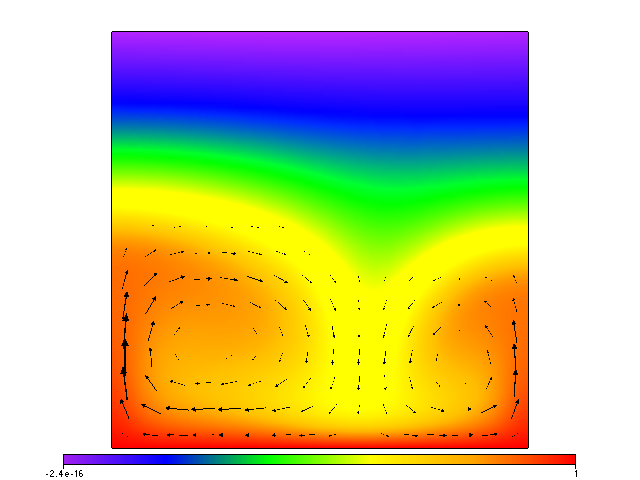

In [9]:
velmax = np.amax(velocityField.data[:])
if(velmax==0.0): velmax = 1.0
figtemp = plt.Figure()
tempminmax = fn.view.min_max(temperatureField)
figtemp.Surface(tempminmax, elementMesh)
figtemp.VectorArrows(velocityField, linearMesh, lengthScale=0.1/velmax, arrowHeadSize=0.2 )
figtemp.show()

Set Dirichlet boundary conditions
------

Use the Dirichlet condition function to flag the boundary vertices (set in IWalls and JWalls) that the system will consider as fixed boundary conditions.

In [10]:
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
AllWalls = IWalls + JWalls

freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(AllWalls,JWalls) )
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

Ensure temperature boundaries conditions are still what we want as the initial conditions above might have set slightly different values on the boundaries.

In [11]:
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = Temp_Max
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = Temp_Min

Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

Notes:
1. temperature must be in the range 0-1 for use with the denisity function defined using the Rayleigh number
2. viscosityFn must be a function of something for the Stokes system below.
3. this can either be done by making it explicitly a function of an existing FEVariable; e.g. of temperatureField
4. OR a function of a fn class object; e.g. of fn.math.exp(0.0), which equals 1
5. OR defined viscosityFn as a FEvariable itself

In [12]:
# Rheology
eta0 = 1.0e-6
activationEnergy = 27.63102112
Ra = 1.e6
viscosityFn = eta0 * fn.math.exp( activationEnergy / (temperatureField+1.) )

densityFn = Ra*temperatureField
# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )
# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = z_hat*densityFn


Plot the viscosity
-----

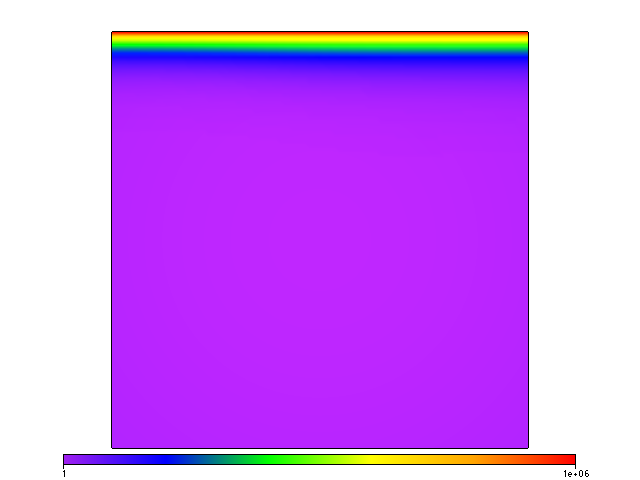

In [13]:
figEta = plt.Figure()
figEta.Surface(viscosityFn, linearMesh)
figEta.show()

Solver settings
=====

Set up parameters for the Stokes system solver. For PIC style integration, we include a swarm for the a PIC integration swarm is generated within. For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.

In [14]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn), 
                              bodyForceFn=buoyancyFn )

solver=uw.systems.Solver(stokesPIC)

solver.options.main.Q22_pc_type='uw'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 1.0
solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-3
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1
solver.options.mg.levels = 5
solver.options.mg.mg_levels_ksp_type = 'chebyshev'
solver.options.mg_accel.mg_accelerating_smoothing = True
solver.options.mg_accel.mg_accelerating_smoothing_view = False
solver.options.mg_accel.mg_smooths_to_start = 1

stokesPIC.solve = solver.solve



We can check what settings and defaults are currently set

In [15]:
print "## Solver Config"
print solver.options.main.list()
print "### A11 Config"
print solver.options.A11.list()

## Solver Config
('remove_constant_pressure_null_space', False)
('ksp_k2_type', 'GMG')
('change_backsolve', False)
('penalty', 1.0)
('pc_type', 'none')
('force_correction', True)
('k_scale_only', True)
('Q22_pc_type', 'uw')
('change_A11rhspresolve', False)
('ksp_type', 'bsscr')
('rescale_equations', False)
('restore_K', True)
None
### A11 Config
('ksp_type', 'fgmres')
('ksp_rtol', 0.0001)
None


Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [16]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )

Non-dimensional rms velocity
----
For comparison with the Blankenbach benchmark results the root mean squared velocity is used. This is defined by intergrating over the entire simulation domain via
\\[
\begin{aligned}
v_{rms} & = \frac{h}{\kappa} \left[ \frac{1}{hl} \int_0^l \int_0^h (u^2 + w^2) dz dx  \right]^{1/2} \\
 & =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]
where $V$ denotes the entire 'volume' of the box, which is the x, z surface for a 2D simulation.

This can be setup in underworld by defining the following functions as integrals of other functions. Here v2sum_integral is defined as the integral over the entire mesh of the function which is $\mathbf{v}.\mathbf{v}$. This is used in the main time loop to calculate statistics and compare to the benchmark results when the system is in steady-state.

In [17]:
v2sum_integral  = uw.utils.Integral( feMesh=linearMesh, fn=fn.math.dot(velocityField, velocityField) ) 
volume_integral = uw.utils.Integral( feMesh=linearMesh, fn=1. )

Setup up surface integrals for Nussel number calculation
-----

In [18]:
#surface_Tgradient = uw.utils.Integral(temperatureField.gradientFn[1], linearMesh, integrationType="surface", surfaceIndexSet=linearMesh.specialSets["MaxJ_VertexSet"])
#basalT            = uw.utils.Integral(temperatureField              , linearMesh, integrationType="surface", surfaceIndexSet=linearMesh.specialSets["MinJ_VertexSet"])

Temporary Patch: Surface integrals currently disabled (22/09/2015)
=======

Use alternate method for calculating the Nusselt number

In [19]:
def FindNusseltNumber(temperatureField, linearMesh, xmax, zmax):
    tempgradField = temperatureField.gradientFn
    vertGradField = tempgradField[1]
    BottomInt = 0.0
    GradValues = temperatureField.gradientFn[1].evaluate(linearMesh.specialSets["MaxJ_VertexSet"])
    TopInt = sum(GradValues)
    for index in linearMesh.specialSets["MinJ_VertexSet"]:
        BottomInt += temperatureField.data[index]
    Nu = -zmax*TopInt/BottomInt
    return Nu[0]

Initialise time the step counts. Based on previous statistics output if required.

In [20]:
# Stepping. Initialise time and timestep.
steps_prev = len(time_vals)
steps = 0
steps_end = 100
step_out = 25

# set time to zero, unless we are loading from file
try:
    time_start = time_vals[-1]
except:
    time_start = 0.0
print 'Begining at t = ',time_start,' after having completed ',steps_prev,' steps'

simtime = time_start


Begining at t =  0.0388546520796  after having completed  1000  steps


In [22]:
# used for CPU timing
start = time.clock()

# Perform steps_end steps
volume = volume_integral.integrate()
rms_v, nu_no = 0.0, 0.0
while steps<steps_end:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if steps == 0:
        dt = 0.
    # Advect using this timestep siz    
    advDiff.integrate(dt)
    
    # Calculate the RMS velocity
    v2sum = v2sum_integral.integrate()
    rms_v = math.sqrt(v2sum[0]/volume[0])
    # comment out surface integral as they are disabled 22/09/2015
    # nu_no = -surface_Tgradient.integrate()[0] / basalT.integrate()[0]
    nu_no = FindNusseltNumber(temperatureField, linearMesh, Box_Length, Box_Height)
    
    # Increment time and store results
    simtime += dt
    steps += 1
    vrms_vals.append( rms_v )
    time_vals.append( simtime )
    Nu_vals.append(nu_no)
                   
    if steps ==0 or steps % step_out == 0:
        print "steps = {:04d}; time = {:.6e}, vrms = {:6.2f}, nusselt = {:6.4f}, CPU = {:4.1f}s".format(
               steps, simtime, rms_v, nu_no, time.clock()-start)
        
v2sum = v2sum_integral.integrate()
rms_v = math.sqrt(v2sum[0]/volume[0])
# nu_no = -surface_Tgradient.integrate()[0] / basalT.integrate()[0]
nu_no = FindNusseltNumber(temperatureField, linearMesh, Box_Length, Box_Height)

print "steps = {:04d}; time = {:.6e}, vrms = {:6.2f}, nusselt = {:6.4f}, CPU = {:4.1f}s".format(
               steps, simtime, rms_v, nu_no, time.clock()-start)


steps = 0025; time = 3.955904e-02, vrms =  36.00, nusselt = 1.0500, CPU = 13.0s
steps = 0050; time = 4.028867e-02, vrms =  36.27, nusselt = 1.0527, CPU = 26.6s
steps = 0075; time = 4.101470e-02, vrms =  36.52, nusselt = 1.0555, CPU = 40.0s
steps = 0100; time = 4.173750e-02, vrms =  36.77, nusselt = 1.0586, CPU = 53.3s
steps = 0100; time = 4.173750e-02, vrms =  36.77, nusselt = 1.0586, CPU = 53.4s


Output timing for calculation per simulation time step

In [24]:
if(steps!=steps_prev):
    avtime = (time.clock() - start)/float(steps)
else:
    avtime = 0.0

print "Average time per timestep = ",avtime," seconds over ", steps, " steps"

Average time per timestep =  0.53457661  seconds over  100  steps


Pre-run model took about $1.74$ seconds per timestep and was run for $13000$ timesteps for $Ra = 10^6$ for a $64\times64$ grid.

Save data to files
-----------

Save system summary data; $v_{rms}$ and the Nusselt number against time.

In [25]:
np.savetxt(outputPath+'ArrSumary.out', (time_vals, vrms_vals, Nu_vals), fmt="%s")

Save final temperature, velocity and pressure fields.

In [26]:
temperatureField.save(outputPath+'Arrhenius_T.out')
velocityField.save(outputPath+'Arrhenius_v.out')
pressureField.save(outputPath+'Arrhenius_P.out')

Plot temperature field with velocity vectors overlaid
------------

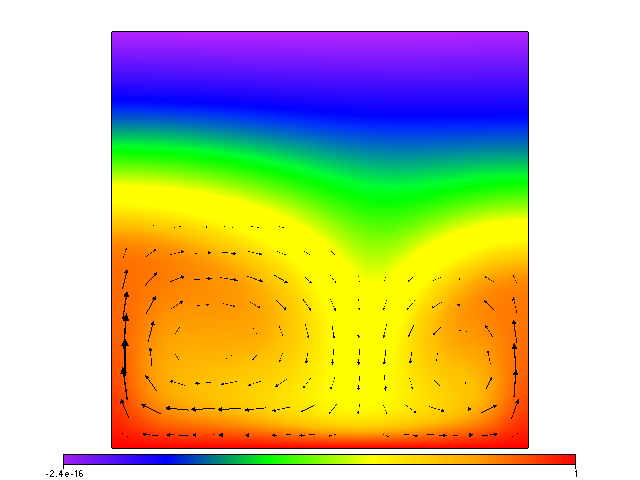

In [27]:
velmax = np.amax(velocityField.data[:])
figVT = plt.Figure()
figVT.Surface(temperatureField, linearMesh)
figVT.VectorArrows(velocityField, linearMesh, lengthScale=0.1/velmax, arrowHeadSize=0.2 )
figVT.show()

Temperature range
-----

Note that the temperature variable has a dynamic range of temperature, which means that it can have values outside the original temperature range (including negative values). Large deviations from the original range are typically due to numerical overshoot due to a low resolution of the system.

Plot system summary information
-----

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


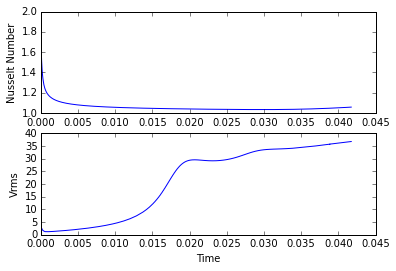

In [28]:
%pylab inline
pyplot.figure(1)
pyplot.subplot(211)
pyplot.plot(time_vals,Nu_vals)
pyplot.ylabel('Nusselt Number')

pyplot.subplot(212)
pyplot.plot(time_vals,vrms_vals)
pyplot.xlabel('Time')
pyplot.ylabel('Vrms')
pyplot.show()
